In [1]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import matplotlib
from scipy import stats
import pandas as pd
import seaborn as sns

import pytensor
from pytensor import tensor as pt
from prophet_rebuild import  trend_model, seasonal_model, det_trend, det_seasonality, prep_raw_data

# Python
import pandas as pd
from prophet import Prophet

import warnings
warnings.filterwarnings("ignore")

sns.set(style='white')

%load_ext autoreload
%autoreload 2

In [2]:
# Read and prep data
df_raw = pd.read_csv('peyton_manning.csv')
df = prep_raw_data(df_raw)

In [3]:
# Set hyper parameters
trend_params = {
    "t": df['t'],
    "n_changepoints": 10,               # default 25
    "changepoints_prior_scale":0.05,    # default 0.05
}

yearly_params = {
    "time_column": df["ds"],
    "time_column_scaled": df['t'],
    "period": "yearly",
    "seasonality_prior_scale": 10       # default 10
}

weekly_params = {
    "time_column": df["ds"],
    "time_column_scaled": df['t'],
    "period": "weekly",
    "seasonality_prior_scale":  10       # default 10
}


# Map estimates

In [4]:
# Create model with pymc
add_seasonality = True

model = pm.Model()

with model:
    y, A, s = trend_model(model, **trend_params)

    if add_seasonality:
        X_yearly, beta_yearly = seasonal_model(model, **yearly_params)
        X_weekly, beta_weekly = seasonal_model(model, **weekly_params)
        y += pt.dot(X_yearly, beta_yearly) + pt.dot(X_weekly, beta_weekly)

    noise = pm.HalfNormal('noise', 0.5)
    obs = pm.Normal('obs',
                 mu=y,
                 sigma=noise,
                 observed=df['y_scaled'])

In [5]:
# Find a point estimate of the models parameters
with model:
    aprox = pm.find_MAP()

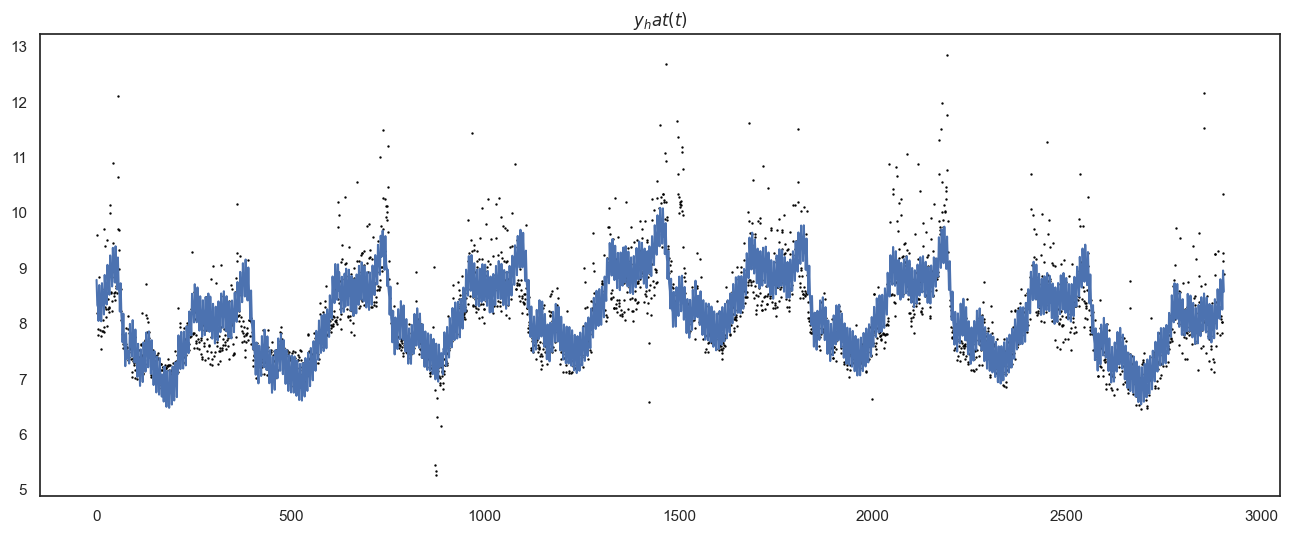

In [6]:
# Determine values with aproximated parameters and rescale to original scale
g = det_trend(aprox['k'], aprox['m'], aprox['delta'], df['t'], s, A) * df['y'].max()
s_yearly = det_seasonality(aprox["beta_yearly"], X_yearly)* df['y'].max()
s_weekly = det_seasonality(aprox["beta_weekly"], X_weekly)* df['y'].max()
y_hat_own_rebuild = pd.Series(g+s_yearly+ s_weekly)

# Plot result
plt.figure(figsize=(16, 6))
plt.title('$y_hat(t)$')
plt.plot(y_hat_own_rebuild)
plt.scatter(np.arange(df.shape[0]), df.y, s=0.5, color='black')

In [7]:
# Benchmark with prophet
m = Prophet(
                n_changepoints=25,
                weekly_seasonality=False,
                yearly_seasonality=False,
                changepoint_prior_scale=trend_params["changepoints_prior_scale"],
            )

m.add_seasonality(
                    name="yearly",
                    period=365.25,
                    fourier_order=10,
                    prior_scale=yearly_params["seasonality_prior_scale"],
                )


m.add_seasonality(
                    name="weekly",
                    period=7,
                    fourier_order=3,
                    prior_scale=weekly_params["seasonality_prior_scale"],
                )

m.fit(df)

# Python
future = m.make_future_dataframe(periods=0)
forecast = m.predict(future)

09:15:20 - cmdstanpy - INFO - Chain [1] start processing
09:15:21 - cmdstanpy - INFO - Chain [1] done processing


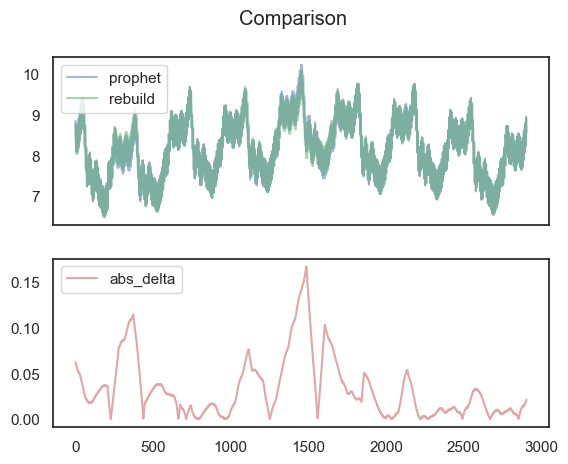

In [8]:
# Compare own rebuild to prophet
abs_delta = abs(forecast["yhat"]-y_hat_own_rebuild)

fig, (ax1, ax2) = plt.subplots(2, sharex=True)
fig.suptitle('Comparison')
ax1.plot(forecast["yhat"], alpha=0.5, color='b', label="prophet")
ax1.plot(y_hat_own_rebuild, alpha=0.5, color='g', label='rebuild')
ax1.legend(loc='upper left')
ax2.plot(abs_delta, alpha=0.5, color='r', label='abs_delta')
ax2.legend(loc='upper left')

## Full bayesian inference

In [5]:
inference_model = pm.Model()

with inference_model:
    y, A, s = trend_model(inference_model, **trend_params)

    noise = pm.HalfNormal('noise', 0.5)
    obs = pm.Normal('obs',
                 mu=y,
                 sigma=noise,
                 observed=df['y_scaled'])

    full_trend_trace = pm.sample(200)

Only 200 samples in chain.
2023-02-06 21:42:42.371 WARNING pymc: Only 200 samples in chain.
Auto-assigning NUTS sampler...
2023-02-06 21:42:43.387 INFO    pymc: Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2023-02-06 21:42:43.388 INFO    pymc: Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
2023-02-06 21:42:45.233 INFO    pymc: Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, m, delta, noise]
2023-02-06 21:42:45.234 INFO    pymc: NUTS: [k, m, delta, noise]


Sampling 4 chains for 1_000 tune and 200 draw iterations (4_000 + 800 draws total) took 1161 seconds.
2023-02-06 22:02:06.917 INFO    pymc: Sampling 4 chains for 1_000 tune and 200 draw iterations (4_000 + 800 draws total) took 1161 seconds.
